In [1]:
# @title
# --- INSTALL & IMPORTS ---

!pip install -q yfinance matplotlib seaborn

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set(style="whitegrid")

# --- CONFIGURATION VARIABLES ---

# Analysis horizon
START_DATE = "2013-08-01"
END_DATE   = "2025-07-01"

# CIP horizon: 1-month = 1/12, 3-month = 0.25
T_CIP = 1/12

# Smoothing window (in months)
SMOOTH_WINDOW = 3

# Toggle: simulate forward (True) or use real forward data (False if you add it later)
USE_SIMULATED_FORWARD = True

# Simulation noise for forward pricing (market micro deviations)
NOISE_STD = 0.002

print("Imports loaded and configuration initialized.")


Imports loaded and configuration initialized.


In [3]:
# --- LOAD INTEREST RATE SERIES (US & AU) ---

from google.colab import files

print("Please upload: DGS3MO.csv (US 3M rate) and IR3TIB01AUQ156N.csv (AU 3M rate)")
uploaded = files.upload()
print("Uploaded files:", uploaded.keys())

def load_rate_series(path, col_name):
    """Load a CSV FRED-style rate series and return tidy monthly-level data."""
    df = pd.read_csv(path)
    df.columns = ["DATE", col_name]
    df["DATE"] = pd.to_datetime(df["DATE"])
    df.set_index("DATE", inplace=True)
    df = df.sort_index()
    return df

# Load US & AU rates
r_us = load_rate_series("DGS3MO.csv", "r_us")          # US 3M T-bill
r_au = load_rate_series("IR3TIB01AUQ156N.csv", "r_au") # AU 3M interbank rate

# --- Merge + Monthly alignment ---
rates = pd.concat([r_us, r_au], axis=1)

# Convert to monthly frequency (end of month)
rates = rates.resample("M").last()

# Forward fill missing values (common in FRED monthly data)
rates = rates.ffill()

# DROP any rows where BOTH rates are missing (rare)
rates = rates.dropna(how="all")

print("\nCleaned & merged rate dataset:")
display(rates.head(5))
display(rates.tail(5))

print("\nRemaining NaNs per column:")
print(rates.isna().sum())

print(f"\nFinal dataset shape: {rates.shape}")


Please upload: DGS3MO.csv (US 3M rate) and IR3TIB01AUQ156N.csv (AU 3M rate)


Saving DGS3MO.csv to DGS3MO.csv
Saving IR3TIB01AUQ156N.csv to IR3TIB01AUQ156N.csv
Uploaded files: dict_keys(['DGS3MO.csv', 'IR3TIB01AUQ156N.csv'])

Cleaned & merged rate dataset:


/tmp/ipython-input-4183513618.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rates = rates.resample("M").last()


,r_us,r_au
DATE,,
2013-01-31,NaN,2.996667
2013-02-28,NaN,2.996667
2013-03-31,NaN,2.996667
2013-04-30,NaN,2.880000
2013-05-31,NaN,2.880000


,r_us,r_au
DATE,,
2025-03-31,4.32,4.206667
2025-04-30,4.31,3.830000
2025-05-31,4.36,3.830000
2025-06-30,4.41,3.830000
2025-07-31,4.40,3.623333



Remaining NaNs per column:
r_us    10
r_au     0
dtype: int64

Final dataset shape: (151, 2)


In [5]:
# --- LOAD AUD/USD SPOT RATE (MONTHLY) ---

# Download daily AUD/USD spot from Yahoo Finance
spot_raw = yf.download("AUDUSD=X", start=START_DATE, end=END_DATE, progress=False)

# Validate download
if spot_raw.empty:
    raise ValueError("Error: AUD/USD data not downloaded. Check ticker or internet connection.")

# Extract adjusted close / close
spot = spot_raw["Close"].copy()
spot.name = "AUDUSD"

# Convert index to datetime and resample to end-of-month average
spot.index = pd.to_datetime(spot.index)
spot = spot.resample("M").mean()

print("Monthly AUD/USD spot rate (average of daily data):")
display(spot.head())
display(spot.tail())

print(f"\nTotal monthly observations: {spot.shape[0]}")


Monthly AUD/USD spot rate (average of daily data):


/tmp/ipython-input-4216977819.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spot_raw = yf.download("AUDUSD=X", start=START_DATE, end=END_DATE, progress=False)
/tmp/ipython-input-4216977819.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  spot = spot.resample("M").mean()


Ticker,AUDUSD=X
Date,
2013-08-31,0.903258
2013-09-30,0.927581
2013-10-31,0.951494
2013-11-30,0.933456
2013-12-31,0.898514


Ticker,AUDUSD=X
Date,
2025-02-28,0.630119
2025-03-31,0.630299
2025-04-30,0.627581
2025-05-31,0.643528
2025-06-30,0.650010



Total monthly observations: 143


In [6]:
# --- MERGE SPOT + INTEREST RATES INTO MASTER DATASET ---

# Align spot & rates and drop months with missing values in any series
df = pd.concat([spot, rates], axis=1)

# Rename columns clearly
df.columns = ["AUDUSD", "r_us", "r_au"]

# Drop rows where *any* of the three are missing
df = df.dropna(how="any")

print("Merged monthly dataset: AUDUSD + US 3M + AU 3M")
display(df.head())
display(df.tail())

print(f"\nFinal dataset shape: {df.shape}")
print("\nRemaining NaNs per column:")
print(df.isna().sum())


Merged monthly dataset: AUDUSD + US 3M + AU 3M


,AUDUSD,r_us,r_au
2013-11-30,0.933456,0.06,2.586667
2013-12-31,0.898514,0.07,2.586667
2014-01-31,0.886307,0.02,2.633333
2014-02-28,0.896497,0.05,2.633333
2014-03-31,0.906614,0.05,2.633333


,AUDUSD,r_us,r_au
2025-02-28,0.630119,4.32,4.206667
2025-03-31,0.630299,4.32,4.206667
2025-04-30,0.627581,4.31,3.830000
2025-05-31,0.643528,4.36,3.830000
2025-06-30,0.650010,4.41,3.830000



Final dataset shape: (140, 3)

Remaining NaNs per column:
AUDUSD    0
r_us      0
r_au      0
dtype: int64


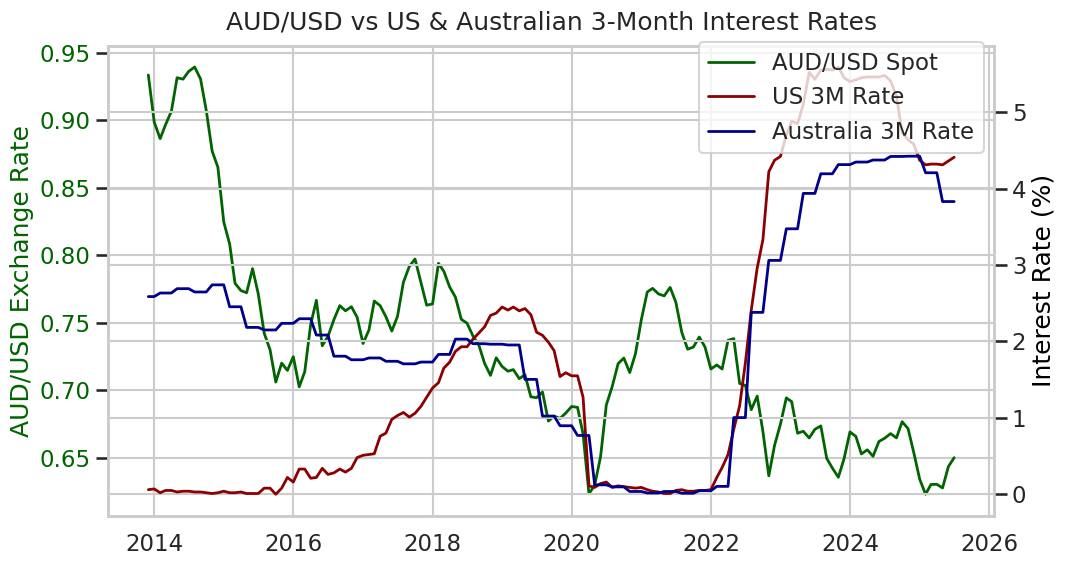

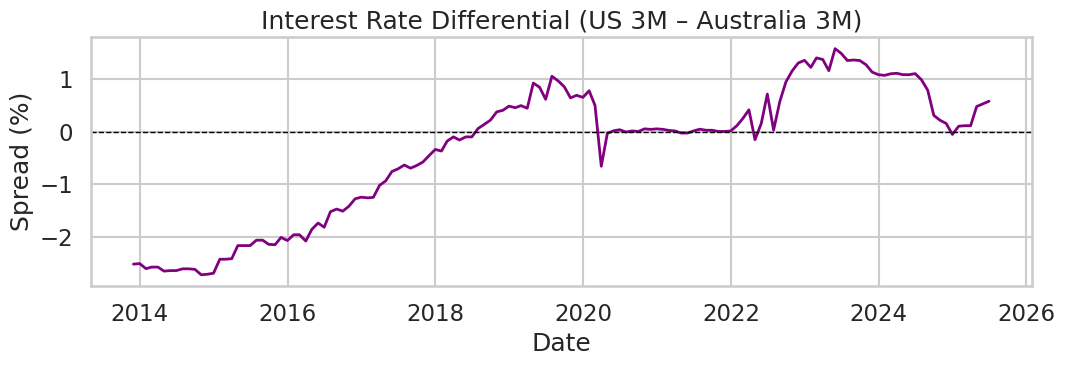

In [10]:
# --- DESCRIPTIVE PLOTS: AUD/USD + INTEREST RATES ---

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

# --- Combined plot: Spot rate + interest rates ---
fig, ax1 = plt.subplots(figsize=(11,6))

# Plot AUD/USD (left y-axis)
ax1.plot(df.index, df["AUDUSD"], color="darkgreen", lw=2, label="AUD/USD Spot")
ax1.set_ylabel("AUD/USD Exchange Rate", color="darkgreen")
ax1.tick_params(axis="y", labelcolor="darkgreen")

# Add secondary axis for interest rates
ax2 = ax1.twinx()
ax2.plot(df.index, df["r_us"], color="darkred", lw=2, label="US 3M Rate")
ax2.plot(df.index, df["r_au"], color="darkblue", lw=2, label="Australia 3M Rate")
ax2.set_ylabel("Interest Rate (%)", color="black")

# Title & legends
plt.title("AUD/USD vs US & Australian 3-Month Interest Rates", pad=12)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(0.92, 0.92))

plt.tight_layout()
plt.show()


# --- Rate differential plot ---
plt.figure(figsize=(11,4))
plt.plot(df.index, df["r_us"] - df["r_au"], color="purple", lw=2)
plt.axhline(0, color="black", linestyle="--", lw=1)
plt.title("Interest Rate Differential (US 3M – Australia 3M)")
plt.ylabel("Spread (%)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


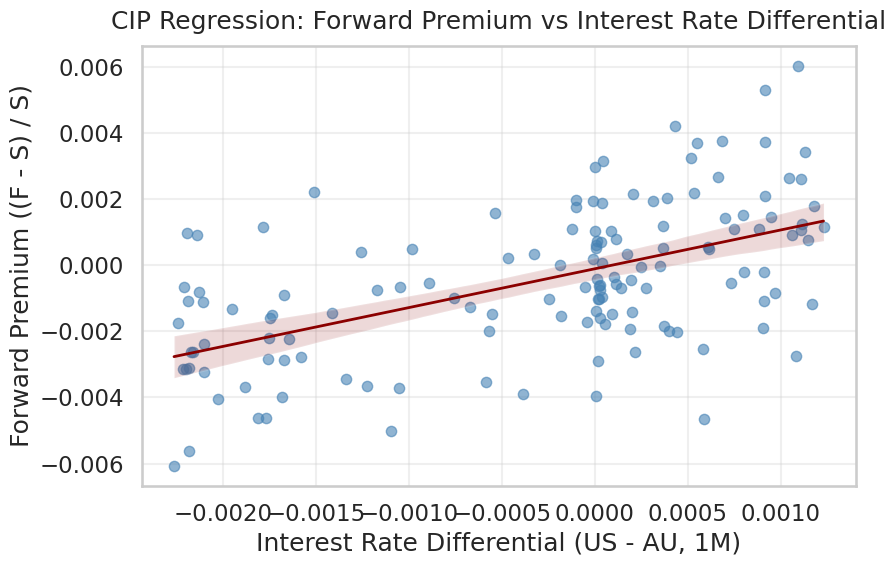

                            OLS Regression Results                            
Dep. Variable:        forward_premium   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     61.51
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           1.08e-12
Time:                        01:00:10   Log-Likelihood:                 680.81
No. Observations:                 140   AIC:                            -1358.
Df Residuals:                     138   BIC:                            -1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0001      0.000     -0.691      0.4

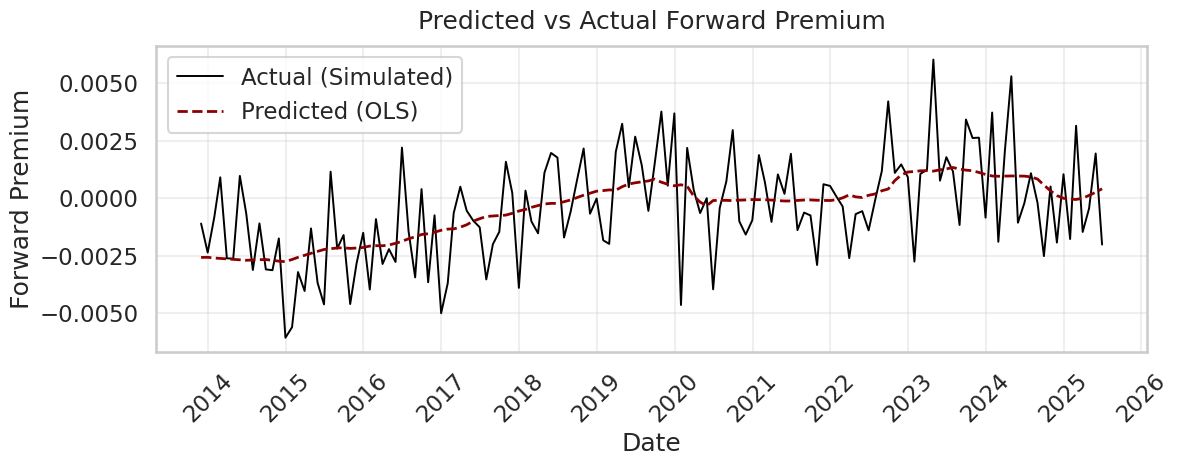

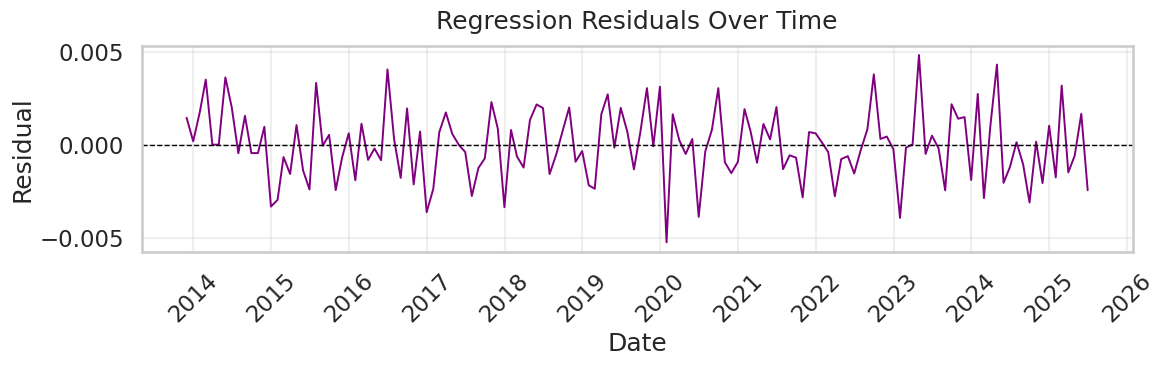

In [13]:
# ============================================================
# CIP plots with clear spacing and labels
# ============================================================

import matplotlib.dates as mdates

# --- 1. Scatter + Regression Line (Clean & Spaced) ---
plt.figure(figsize=(9,6))
sns.regplot(
    x="rate_diff", y="forward_premium", data=reg,
    scatter_kws={"alpha":0.6, "color": "steelblue", "s":55},
    line_kws={"color":"darkred", "lw":2}
)

plt.title("CIP Regression: Forward Premium vs Interest Rate Differential", pad=12)
plt.xlabel("Interest Rate Differential (US - AU, 1M)")
plt.ylabel("Forward Premium ((F - S) / S)")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Regression ---
reg = cip[["forward_premium", "rate_diff"]].dropna()
X = sm.add_constant(reg["rate_diff"])
y = reg["forward_premium"]

model = sm.OLS(y, X).fit()

# --- OLS Regression Output ---
print(model.summary())

# --- Predictions & Residuals ---
reg["predicted"] = model.fittedvalues
reg["residuals"] = model.resid

# --- 2. Predicted vs Actual (With Proper Date Formatting) ---
plt.figure(figsize=(12,5))

plt.plot(
    reg.index, reg["forward_premium"],
    label="Actual (Simulated)", color="black", lw=1.4
)
plt.plot(
    reg.index, reg["predicted"],
    label="Predicted (OLS)", color="darkred",
    linestyle="--", lw=2
)

plt.title("Predicted vs Actual Forward Premium", pad=12)
plt.ylabel("Forward Premium")
plt.xlabel("Date")
plt.legend()

# Format dates so they don't overlap
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# --- 3. Residuals Plot (Clean, Centered, Non-Overlapping) ---
plt.figure(figsize=(12,4))

plt.plot(reg.index, reg["residuals"], lw=1.4, color="purple")
plt.axhline(0, color="black", linestyle="--", lw=1)

plt.title("Regression Residuals Over Time", pad=12)
plt.ylabel("Residual")
plt.xlabel("Date")

# Format dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [9]:
# --- CIP-BASED EXCHANGE RATE FORECAST (1-MONTH AHEAD) ---

# Use the last available values
last_row = cip.iloc[-1]

S_t      = last_row["S"]
r_us_t   = last_row["r_us_smooth"]
r_au_t   = last_row["r_au_smooth"]

# CIP theoretical forward (forecast)
F_CIP = S_t * (1 + r_us_t * T) / (1 + r_au_t * T)

# Regression-adjusted forward (optional, more realistic)
alpha = model.params["const"]
beta  = model.params["rate_diff"]
rate_diff_t = (r_us_t - r_au_t) * T
F_reg = S_t * (1 + alpha + beta * rate_diff_t)

print("=== 1-Month Ahead Forecast (CIP) ===")
print(f"Last spot rate (S_t):       {S_t:.4f}")
print(f"CIP-implied forward:        {F_CIP:.4f}")
print(f"Regression-adjusted forward:{F_reg:.4f}")
print(f"Implied appreciation:       {(F_CIP/S_t - 1)*100:.3f}%")


=== 1-Month Ahead Forecast (CIP) ===
Last spot rate (S_t):       0.6404
CIP-implied forward:        0.6407
Regression-adjusted forward:0.6406
Implied appreciation:       0.044%
